In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
mktcap = pd.read_pickle("ryu_new_mktcap5.pickle")
price = pd.read_pickle("ryu_new_price5.pickle")
vol = pd.read_pickle("ryu_new_volume5.pickle")

weight = mktcap.apply(lambda x: x/ np.nansum(x), axis=1)
rtn = price.pct_change(fill_method=None) * np.sign(price)

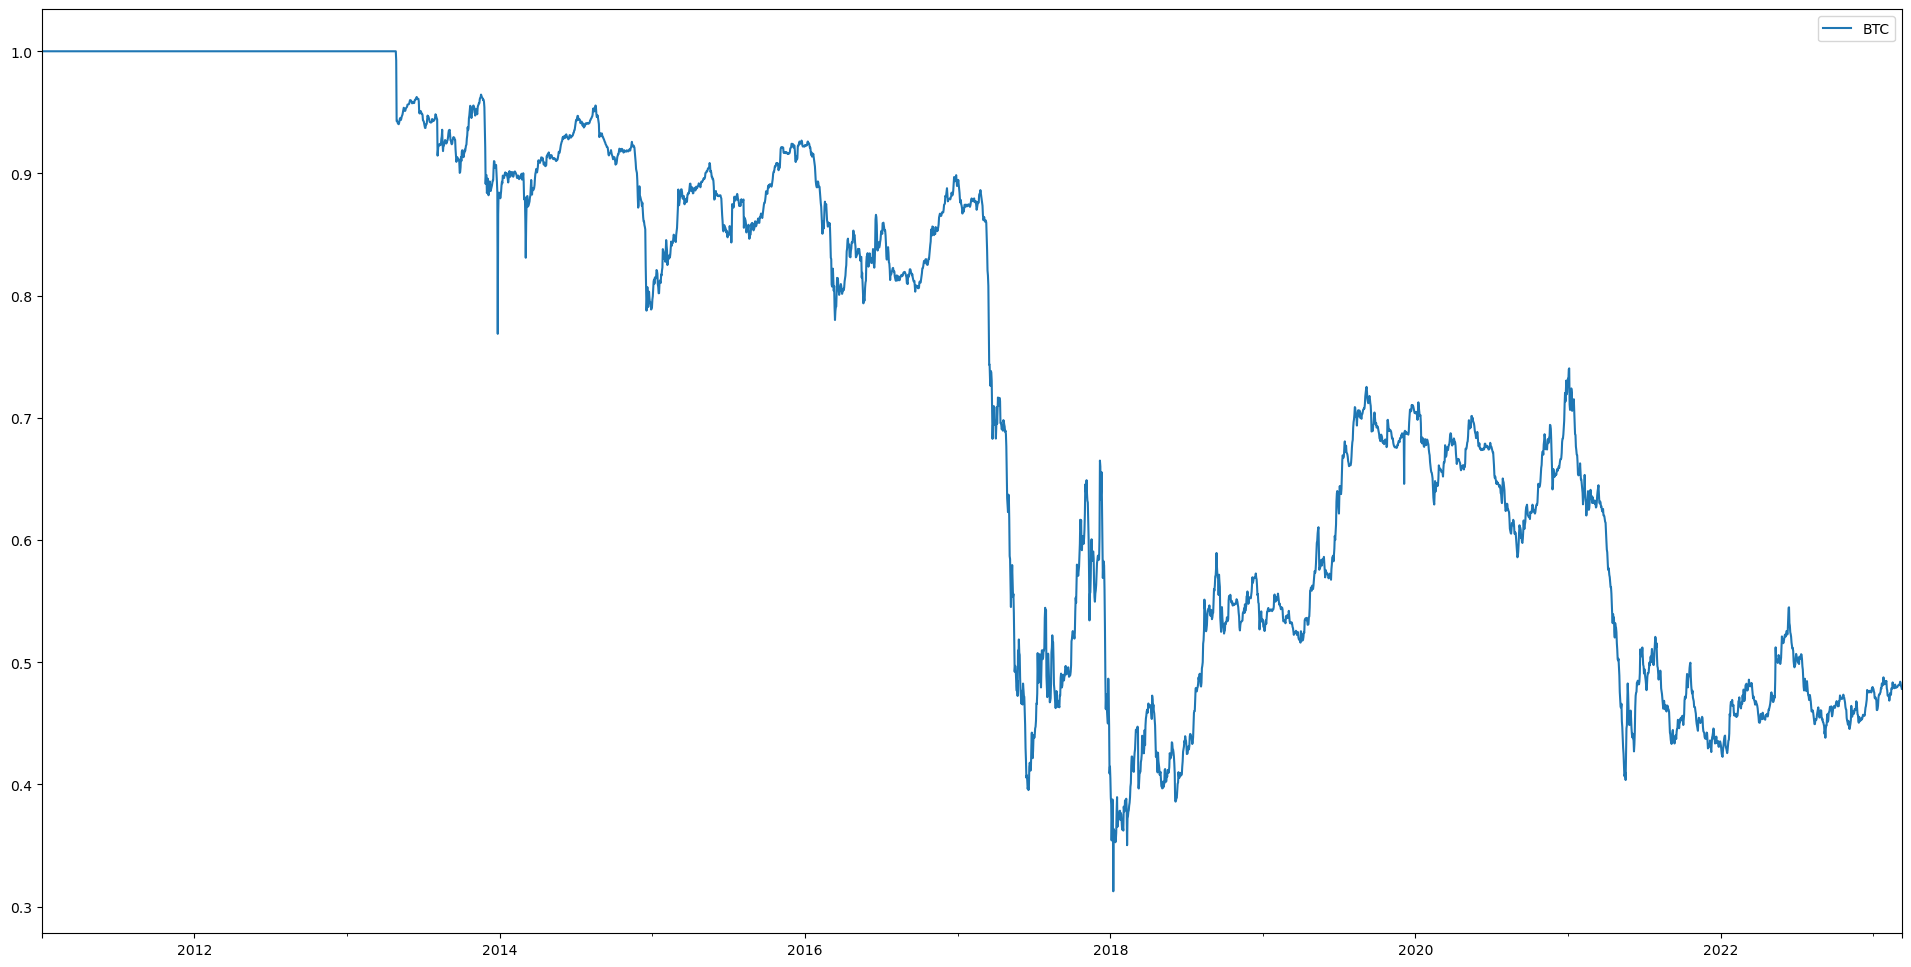

In [7]:
weight[["BTC"]].plot(figsize=(24,12));

# 아직 weight 클리닝이 덜 되었다

step1) 시작하기 전에, mktcap의 MA로 코인들을 다시 스크리닝 해주자

In [72]:
raw_mktcap = pd.read_pickle("ryu_new_mktcap5.pickle")

In [73]:
# MA로 필터링
mktcap_moving_average = raw_mktcap.rolling(20, min_periods=1).mean()
clean_mktcap = raw_mktcap[mktcap_moving_average>1_000_000]

In [74]:
# Sample 코인 (BTC:2013-04-29, XRP:2013-08-05, ETH:2015-08-08)
sample = clean_mktcap[["ETH"]]
sample.loc[sample.isna().values]

,ETH
2011-01-01,NaN
2011-01-02,NaN
2011-01-03,NaN
2011-01-04,NaN
2011-01-05,NaN
...,...
2015-08-03,NaN
2015-08-04,NaN
2015-08-05,NaN
2015-08-06,NaN


In [75]:
# 1로 넣어주는 과정
clean_mktcap.loc[:"2013-04-27", "BTC"]= 1

# 변경된 값 확인
clean_mktcap.loc[:"2013-04-28", ["BTC"]]

,BTC
2011-01-01,1.000000e+00
2011-01-02,1.000000e+00
2011-01-03,1.000000e+00
2011-01-04,1.000000e+00
2011-01-05,1.000000e+00
...,...
2013-04-24,1.000000e+00
2013-04-25,1.000000e+00
2013-04-26,1.000000e+00
2013-04-27,1.000000e+00


In [76]:
clean_mktcap.to_pickle("ryu_new_mktcap5_1.pickle")

Step 4-2) Back to Step 4-2:  mktcap의 sign으로 스크리닝 해준 price의 pct_change를 고려해보자

In [77]:
mktcap = pd.read_pickle("ryu_new_mktcap5_1.pickle")
price = pd.read_pickle("ryu_new_price5.pickle")
vol = pd.read_pickle("ryu_new_volume5.pickle")

weight = mktcap.apply(lambda x: x/ np.nansum(x), axis=1)
rtn = price.pct_change(fill_method=None) * np.sign(price)

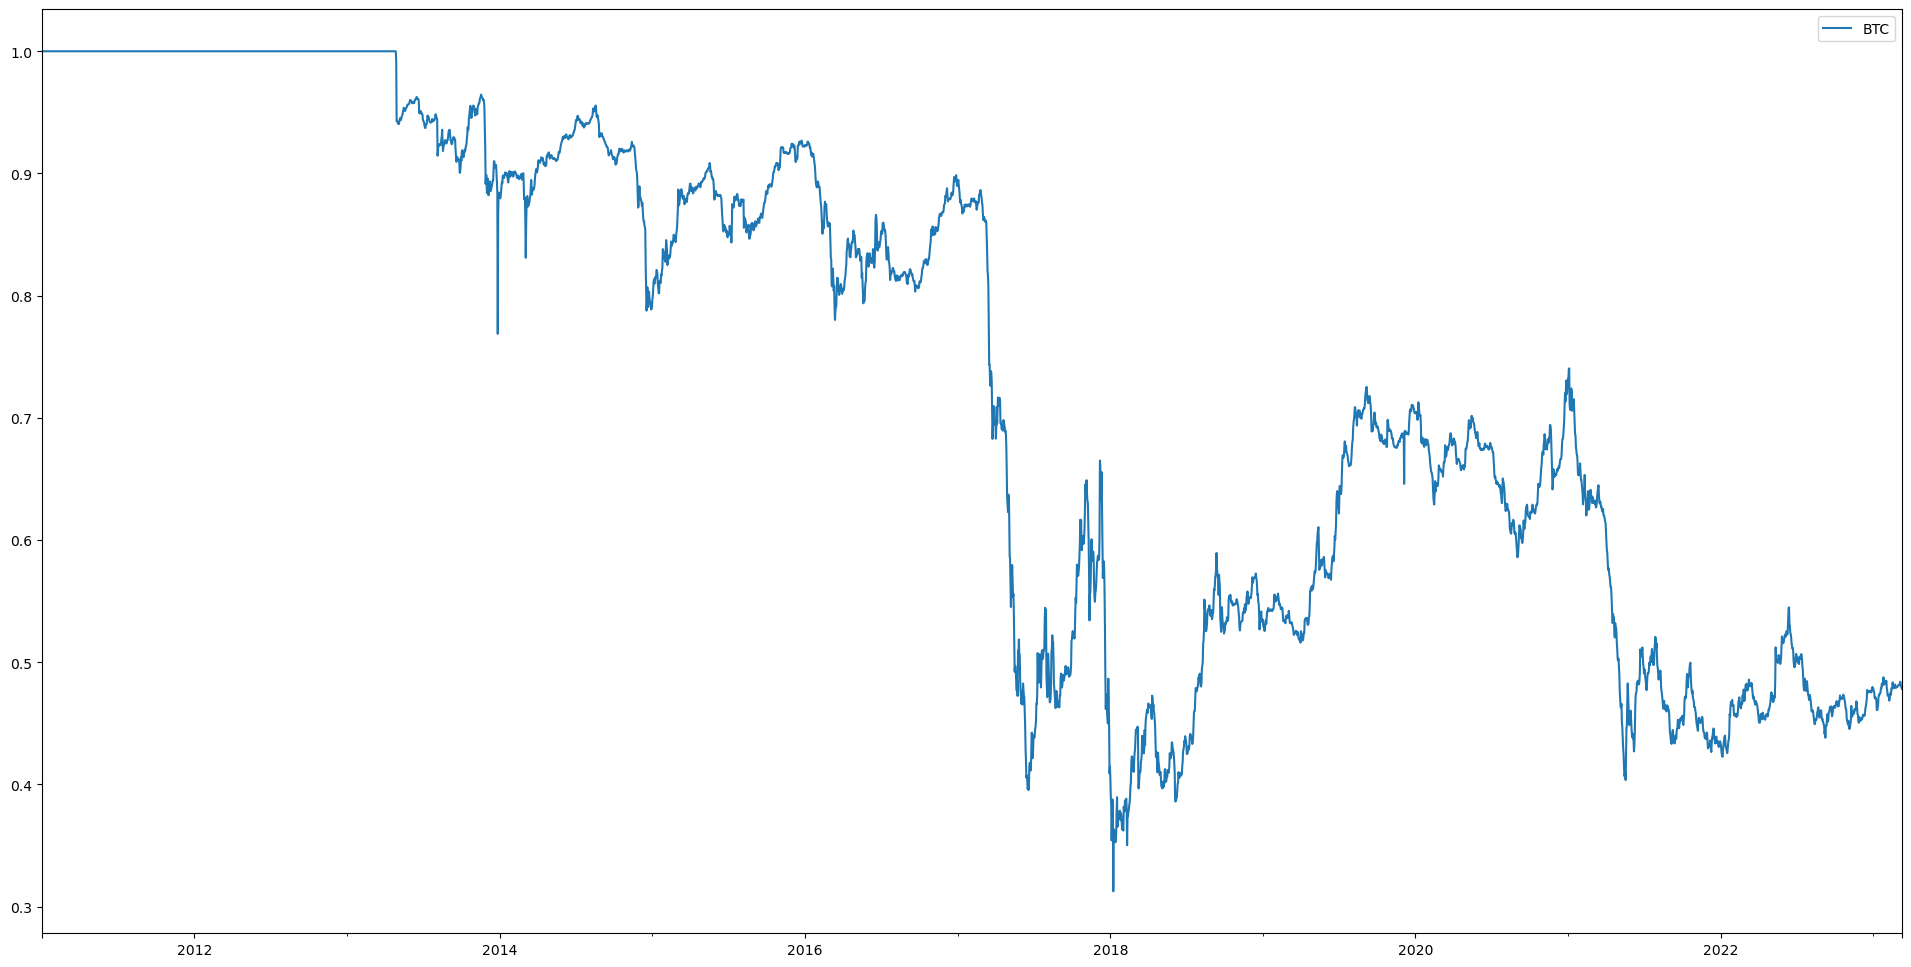

In [78]:
weight[["BTC"]].plot(figsize=(24,12));

# 아직 weight 클리닝이 덜 되었다

In [79]:
# mktcap data is non-zero
(mktcap < 0).sum().sum()

0

In [23]:
mktcap_mask = np.sign(mktcap).replace(0,1)

# Check sign is appropriate
print(np.unique(mktcap_mask.values))
(mktcap_mask <= 0).sum().sum()

[ 1. nan]


0

In [24]:
masked_price = (mktcap_mask * price)

In [26]:
rtn = masked_price.pct_change(fill_method=None) * np.sign(masked_price)

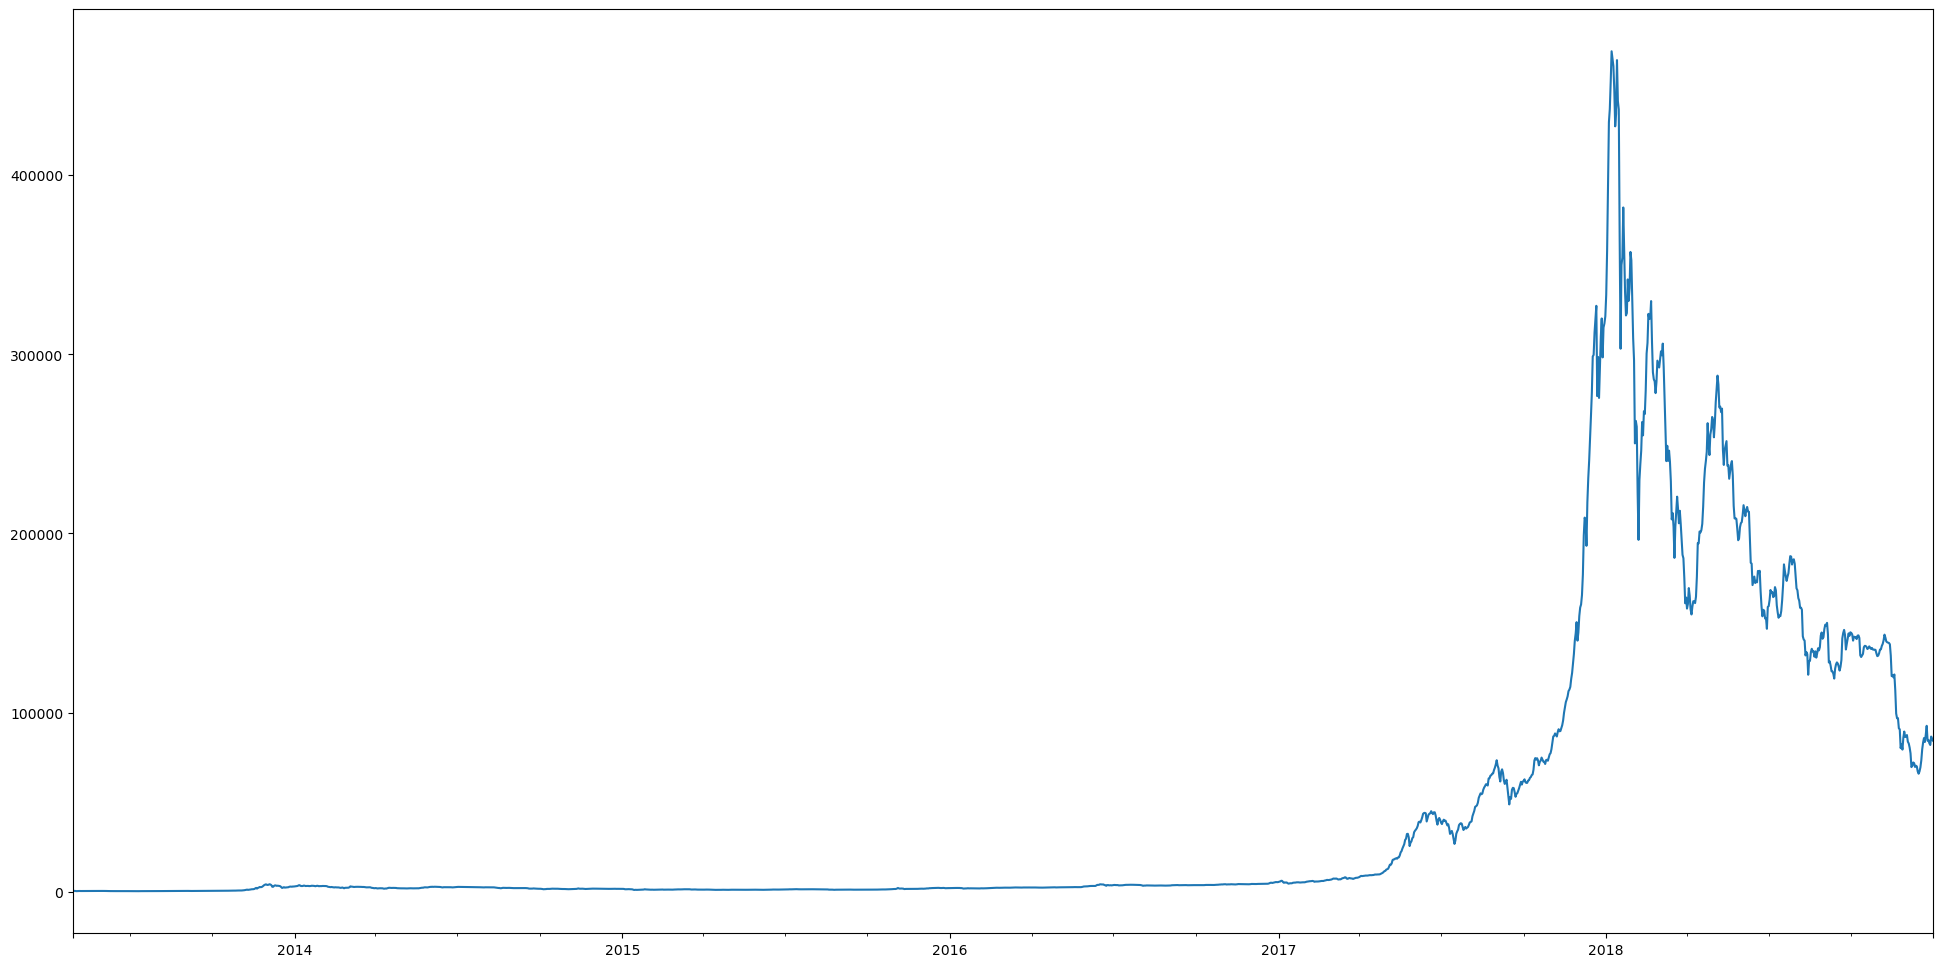

In [33]:
((weight * rtn).sum(1) + 1).cumprod().loc["2013-04-29":"2018-12-31"].plot(figsize=(24,12));

In [57]:
# pct 확인
many = 100
(rtn > many).sum().loc[((rtn > many).sum() > 0).values]

42       1
CARE     1
COCOS    1
DPT2     1
ECOM     1
LRN      1
NSFW     1
OAX      1
OMI      1
VRA      1
XFI      1
dtype: int64

다시 mktcap부터 살펴야한다

In [81]:
mktcap_pct = mktcap.pct_change(fill_method=None)

In [103]:
# 마켓켑이 많이 튀는 친구들
mktcap_problem = (mktcap_pct > 1000).sum().loc[((mktcap_pct > 1000).sum() > 0).values]
mktcap_problem

ADX       1
AMO       1
ANT       1
ARDR      1
BAAS      1
         ..
WINGS     1
XAUR      1
XSN      25
YIN       1
ZOON      1
Length: 71, dtype: int64

In [112]:
print(mktcap_problem.values)
# 25는 뭐지..?

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  3  1  2  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 25  1  1]


In [115]:
# XSN은 드랍하고 시작하자(코인 mktcap에서도 트레킹 불가능)
price_pp = price.drop("XSN", axis=1)
mktcap_pp = mktcap.drop("XSN", axis=1)
vol_pp = vol.drop("XSN", axis=1)

In [116]:
mktcap_pct = mktcap_pp.pct_change(fill_method=None)

In [123]:
# 마켓켑이 많이 튀는 친구들
mktcap_problem = (mktcap_pct > 1000).sum().loc[((mktcap_pct > 1000).sum() > 0).values]
mktcap_problem

ADX      1
AMO      1
ANT      1
ARDR     1
BAAS     1
        ..
WASP     1
WINGS    1
XAUR     1
YIN      1
ZOON     1
Length: 70, dtype: int64

In [124]:
mktcap_pct[["ADX"]].loc[(mktcap_pct[["ADX"]] > 1000).values]

,ADX
2018-03-25,inf


In [138]:
for coin in mktcap_problem.index:
    find = mktcap_pct[[coin]].loc[(mktcap_pct[coin] > 1000).values].index[0]
    start_idx = find - pd.Timedelta(days=5)
    end_idx = find + pd.Timedelta(days=5)
    
    problem = mktcap.loc[start_idx:end_idx, coin]
    price_to_see = price.loc[start_idx:end_idx, coin]
    print(pd.concat([problem, price_to_see], axis=1))

                   ADX       ADX
2018-03-20         NaN  0.783387
2018-03-21         NaN  0.824398
2018-03-22  57903228.0  0.793846
2018-03-23  56008843.0  0.775060
2018-03-24         0.0  0.793729
2018-03-25  58896666.0  0.795271
2018-03-26         0.0  0.752914
2018-03-27         0.0  0.712146
2018-03-28         0.0  0.725239
2018-03-29         0.0  0.693453
2018-03-30         0.0  0.602017
                   AMO       AMO
2018-09-19         0.0  0.001633
2018-09-20         0.0  0.001660
2018-09-21         0.0  0.001654
2018-09-22         0.0  0.001630
2018-09-23         0.0  0.001645
2018-09-24  29635054.0  0.001559
2018-09-25  28911835.0  0.001446
2018-09-26  29255793.0  0.001463
2018-09-27  31130065.0  0.001557
2018-09-28  37352845.0  0.001868
2018-09-29  34144161.0  0.001707
                     ANT   ANT
2018-03-20           NaN  3.02
2018-03-21           NaN  3.89
2018-03-22  1.041711e+08  4.02
2018-03-23  9.754300e+07  3.66
2018-03-24  0.000000e+00  3.65
2018-03-25  8.869872e+

하다가.... 너무 처리할 게 많기 때문에, mktcap이 0인 것들은 죄다 np.nan으로 바꿔버리자

In [139]:
mktcap_nan = mktcap.replace(0, np.nan)

In [ ]:
mktcap_nan.to_pickle("ryu_new_mktcap6_1.pickle")